# Trabajo Práctico Nº3

**Integrantes**:
- Carolina Perez Omodeo
- Emiliano Uriel Martino
- Alan Perez Winter

**Objetivos**:
Encontrar el logotipo de la gaseosa dentro de las imágenes provistas en ``./tp3/images`` a partir del template ``./tp3/template``
1. (4 puntos) Obtener una detección del logo en cada imagen sin falsos positivos
2. (4 puntos) Plantear y validar un algoritmo para múltiples detecciones en la imagen
coca_multi.png con el mismo témplate del item 2
1. (2 puntos) Generalizar el algoritmo del item 2 para todas las imágenes.
Visualizar los resultados con bounding boxes en cada imagen mostrando el nivel de confianza
de la detección.

In [1]:
import os
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from imutils.object_detection import non_max_suppression

In [2]:
TEMPLATE = os.getcwd() + "/template/pattern.png"
LOGO_1 = os.getcwd() + "/images/logo_1.png"
LOGO_2 = os.getcwd() + "/images/COCA-COLA-LOGO.jpg"
LOGO_3 = os.getcwd() + "/images/coca_logo_1.png"
LOGO_4 = os.getcwd() + "/images/coca_logo_2.png"
LOGO_5 = os.getcwd() + "/images/coca_retro_1.png"
LOGO_6 = os.getcwd() + "/images/coca_retro_2.png"
MULTI_LOGO = os.getcwd() + "/images/coca_multi.png"

### Template

In [5]:
template = cv.imread(TEMPLATE, cv.IMREAD_GRAYSCALE)
template_blur = cv.GaussianBlur(template, (5, 5), 0)
template_blur_canny = cv.Canny(template_blur, 50, 150)
template_canny = cv.Canny(template, 50, 150)
template_fft = np.fft.fftshift(np.fft.fft2(template))
template_blur_fft = np.fft.fftshift(np.fft.fft2(template_blur))

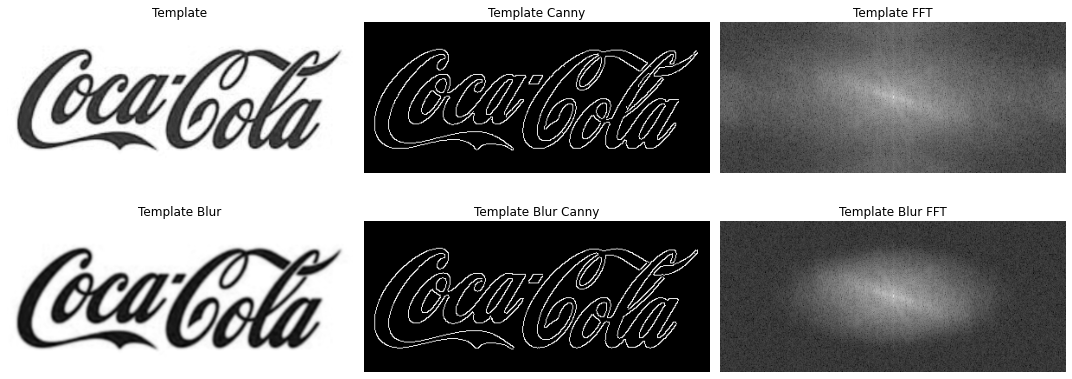

In [6]:
fig, axs = plt.subplots(2, 3, figsize=(15, 6))
axs[0, 0].imshow(template, cmap="gray")
axs[0, 0].set_title("Template")
axs[0, 0].axis("off")
axs[0, 1].imshow(template_canny, cmap="gray")
axs[0, 1].set_title("Template Canny")
axs[0, 1].axis("off")
axs[0, 2].imshow(np.log(1 + np.abs(template_fft)), cmap="gray")
axs[0, 2].set_title("Template FFT")
axs[0, 2].axis("off")
axs[1, 0].imshow(template_blur, cmap="gray")
axs[1, 0].set_title("Template Blur")
axs[1, 0].axis("off")
axs[1, 1].imshow(template_blur_canny, cmap="gray")
axs[1, 1].set_title("Template Blur Canny")
axs[1, 1].axis("off")
axs[1, 2].imshow(20*np.log(1 + np.abs(template_blur_fft)), cmap="gray")
axs[1, 2].set_title("Template Blur FFT")
axs[1, 2].axis("off")

plt.tight_layout()
plt.show()


## PART 1

### Own template matching function

In [7]:
def templateMatching(image, template, min_scale: float=0.5, max_scale: float=1.5, step: float=0.1):
    # Best result variables
    best_score = -1
    best_template = template.copy()
    shape = template.shape[:2]
    corner_loc = (0, 0)

    # Iterate over different scales
    num = int((max_scale-min_scale)/step)+1
    for scale in np.linspace(min_scale, max_scale, num):
        # Copy images
        image_cp = image.copy()
        template_cp = template.copy()

        # Resize the template
        template_cp_rs = cv.resize(template_cp, (0, 0), fx=scale, fy=scale)
        height_cond = image_cp.shape[0] > template_cp_rs.shape[0]
        width_cond = image_cp.shape[1] > template_cp_rs.shape[1]

        if height_cond and width_cond:
            # Color -> B&W
            image_cp = cv.cvtColor(image_cp, cv.COLOR_BGR2GRAY)
            template_cp_rs = cv.cvtColor(template_cp_rs, cv.COLOR_BGR2GRAY)
            
            # Apply bilateral filter to reduce noise but keep edges
            image_cp = cv.bilateralFilter(image_cp, d=9, sigmaColor=75, sigmaSpace=75)
            template_cp_rs = cv.bilateralFilter(template_cp_rs, d=9, sigmaColor=75, sigmaSpace=75)

            # Apply morphological opening to remove small details (noise)
            kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (5, 5))
            image_cp = cv.morphologyEx(image_cp, cv.MORPH_OPEN, kernel)
            template_cp_rs = cv.morphologyEx(template_cp_rs, cv.MORPH_OPEN, kernel)

            # Apply adaptive thresholding to binarize the image
            image_cp = cv.adaptiveThreshold(image_cp, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 11, 2)
            template_cp_rs = cv.adaptiveThreshold(template_cp_rs, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 11, 2)

            # Apply template matching
            result = cv.matchTemplate(image_cp, template_cp_rs, cv.TM_CCOEFF_NORMED)
            min_val, max_val, min_loc, max_loc = cv.minMaxLoc(result)
            
            # Check if the current scale is the best
            if max_val > best_score:
                best_score = max_val
                shape = template_cp_rs.shape
                corner_loc = max_loc
                best_template = template_cp_rs.copy()
    
    # Draw a rectangle around the detected object
    image_cp = image.copy()
    h, w = shape
    bottom_right = (corner_loc[0] + w, corner_loc[1] + h)
    cv.rectangle(image_cp, corner_loc, bottom_right, (0, 255, 0), 2)
    # Add label with confidence factor
    conf_factor = 100 * (best_score - (-1)) / (1 - (-1))
    label = f"Confidence: {conf_factor:.2f}%"
    (label_width, label_height), _ = cv.getTextSize(label, cv.FONT_HERSHEY_SIMPLEX, 1, 2)
    font_scale = (0.75 * w) / label_width
    label_width = int(label_width * font_scale)
    label_height = int(label_height * font_scale)
    text_end = (corner_loc[0] + label_width, corner_loc[1] - label_height)
    cv.rectangle(image_cp, corner_loc, text_end, (0, 0, 0), -1)
    cv.putText(image_cp, label, corner_loc, cv.FONT_HERSHEY_SIMPLEX, font_scale, (0, 255, 0), 2)

    return image_cp, best_template, conf_factor, corner_loc


### Test on Images (one logo per image)

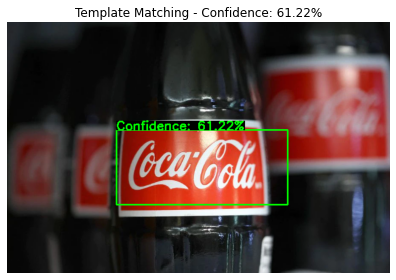

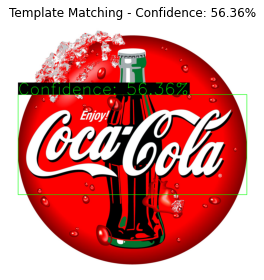

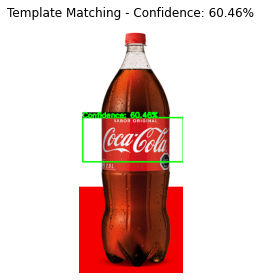

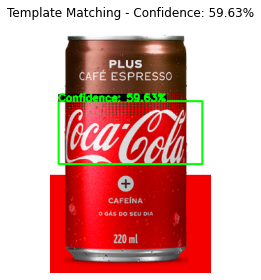

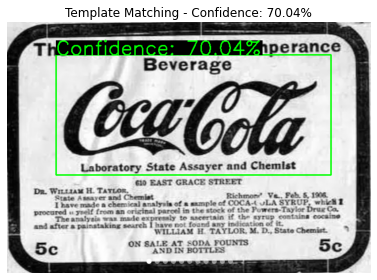

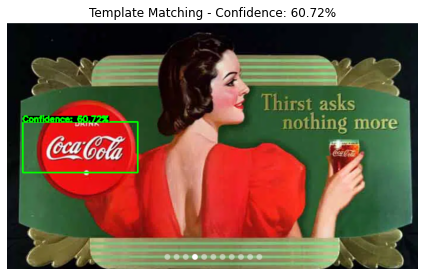

In [8]:
num = 50
template = cv.imread(TEMPLATE)
images = [LOGO_1, LOGO_2, LOGO_3, LOGO_4, LOGO_5, LOGO_6]

for i, img in enumerate(images):
    image = cv.imread(img)
    # Compute min and max scale factor in a smart way to avoid too many iterations
    is_template_higher = (template.shape[0] > template.shape[0]) or (template.shape[1] > template.shape[1])
    if is_template_higher:
        max_scale = max(template.shape[0]/image.shape[0], template.shape[1]/image.shape[1])
        min_scale = max(0.5, max_scale/5)
    else:
        max_scale= min(image.shape[0]/template.shape[0], image.shape[1]/template.shape[1])
        max_scale = max(max_scale, 1.5)
        min_scale = min(0.5, max_scale/3)
    step = (max_scale - min_scale) / num

    # Perform template matching
    min_scale = min_scale if i != 1 else 2
    image_tm, template_tm, confidence, _ = templateMatching(image, template, min_scale, max_scale, step)

    # Plot results
    plt.figure()
    plt.imshow(image_tm[..., ::-1])
    plt.title(f"Template Matching - Confidence: {confidence:.2f}%")
    plt.axis("off")
    plt.tight_layout()
    plt.savefig(f"logo_{i+1}_temp_match.png", facecolor="white")
    plt.show()

## PART 2

Total detecciones antes de NMS: 6036
Total detecciones después de NMS: 18


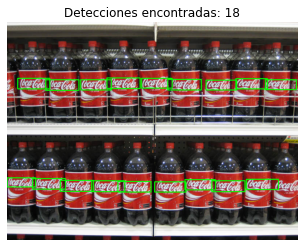

In [10]:
# Cargar la imagen en color y en escala de grises
img_rgb = cv.imread(MULTI_LOGO)
multi_image = cv.cvtColor(img_rgb, cv.COLOR_BGR2GRAY)
template = cv.imread(TEMPLATE, 0)

# Función para realizar template matching con detecciones múltiples
def templateMatchingMultiple(image, template, min_scale=0.5, max_scale=2, step=0.05, threshold=0.5):
    detecciones = []
    num = int((max_scale - min_scale) / step) + 1
    
    for scale in np.linspace(min_scale, max_scale, num):
        # Redimensionar el template
        template_rs = cv.resize(template, (0, 0), fx=scale, fy=scale)
        
        # Verificar si el template escalado cabe en la imagen
        if image.shape[0] >= template_rs.shape[0] and image.shape[1] >= template_rs.shape[1]:
            result = cv.matchTemplate(image, template_rs, cv.TM_CCOEFF_NORMED)
            loc = np.where(result >= threshold)  # Obtener ubicaciones que superen el umbral

            # Almacenar cada detección como una tupla (coordenadas de la esquina superior izquierda, tamaño del template, valor de coincidencia)
            for pt in zip(*loc[::-1]):
                detecciones.append((pt[0], pt[1], template_rs.shape[1], template_rs.shape[0], result[pt[1], pt[0]]))
    
    return detecciones

# Redimensionar imagen y template (factores de escala)
scaling_factor = 2
resized_image = cv.resize(multi_image, (0, 0), fx=scaling_factor, fy=scaling_factor)

inverted_template = cv.bitwise_not(template)
resized_template = cv.resize(inverted_template, (0, 0), fx=1/2, fy=1/2)
cropped_template = resized_template[16:74, 10:190]

# Mostrar template y imagen redimensionada
#plt.imshow(cropped_template, cmap='gray')
#plt.title('Template')
#plt.show()

# Mostrar imagen en color redimensionada
#plt.imshow(cv.cvtColor(img_rgb, cv.COLOR_BGR2RGB))
#plt.title('Image')
#plt.show()

# Realizar template matching con múltiples escalas
detecciones = templateMatchingMultiple(resized_image, cropped_template, min_scale=0.5, max_scale=5, step=0.01, threshold=0.37)
print(f"Total detecciones antes de NMS: {len(detecciones)}")

# Convertir las detecciones a formato [x1, y1, x2, y2] para usar Non-Maximum Suppression
rects = np.array([[x, y, x + w, y + h] for (x, y, w, h, _) in detecciones])

# Aplicar Non-Maximum Suppression usando imutils
detecciones_finales = non_max_suppression(rects, overlapThresh=0.3)

print(f"Total detecciones después de NMS: {len(detecciones_finales)}")

# Dibujar las detecciones finales en la imagen en color (img_rgb)
for (x1, y1, x2, y2) in detecciones_finales:
    # Escalar las coordenadas de vuelta al tamaño original dividiendo por el factor de escalado
    x1 = int(x1 / scaling_factor)
    y1 = int(y1 / scaling_factor)
    x2 = int(x2 / scaling_factor)
    y2 = int(y2 / scaling_factor)
    cv.rectangle(img_rgb, (x1, y1), (x2, y2), (0, 255, 0), 2)

# Mostrar la imagen con todas las detecciones en color
plt.imshow(cv.cvtColor(img_rgb, cv.COLOR_BGR2RGB))
plt.title(f'Detecciones encontradas: {len(detecciones_finales)}')
plt.axis('off')
plt.savefig('multi_logo_temp_match.png', facecolor='white')
plt.show()

In [16]:
def template_matching_multiple(image_path, template_path, min_scale=0.5, max_scale=2, step=0.05, threshold=0.5, use_inverted_template=False, scaling_factor=1):
    """
    Realiza template matching con escalas y devuelve las detecciones.
    
    Parameters:
    - image_path: str. Ruta de la imagen.
    - template_path: str. Ruta del template.
    - min_scale: float. Escala mínima del template.
    - max_scale: float. Escala máxima del template.
    - step: float. Incremento de la escala entre la escala mínima y máxima.
    - threshold: float. Umbral para aceptar una coincidencia como válida.
    - use_inverted_template: bool. Si True, usa el template invertido (colores).
    - scaling_factor: float. Factor de escalado de la imagen.
    
    Returns:
    - Detecciones finales después de aplicar Non-Maximum Suppression.
    - Imagen con los rectángulos dibujados.
    """
    
    # Cargar la imagen en color y convertir a escala de grises
    img_rgb = cv.imread(image_path)
    if img_rgb is None:
        raise ValueError(f"No se pudo cargar la imagen desde la ruta: {image_path}")
    
    image_gray = cv.cvtColor(img_rgb, cv.COLOR_BGR2GRAY)
    
    # Cargar el template en escala de grises
    template = cv.imread(template_path, 0)
    if template is None:
        raise ValueError(f"No se pudo cargar el template desde la ruta: {template_path}")
    
    # Usar el template invertido si se especifica
    if use_inverted_template:
        template = cv.bitwise_not(template)
    
    # Redimensionar la imagen
    resized_image = cv.resize(image_gray, (0, 0), fx=scaling_factor, fy=scaling_factor)
    
    # Redimensionar el template (opcional, si quieres trabajar con un template recortado)
    resized_template = cv.resize(template, (0, 0), fx=1/2, fy=1/2)  # Ajustar según sea necesario
    cropped_template = resized_template[16:74, 10:190]  # Opción de recorte del template

    # Función para realizar el template matching con múltiples escalas
    detecciones = []
    num_scales = int((max_scale - min_scale) / step) + 1
    for scale in np.linspace(min_scale, max_scale, num_scales):
        # Redimensionar el template a cada escala
        template_resized = cv.resize(cropped_template, (0, 0), fx=scale, fy=scale)
        
        # Verificar que el template escalado quepa en la imagen
        if resized_image.shape[0] >= template_resized.shape[0] and resized_image.shape[1] >= template_resized.shape[1]:
            result = cv.matchTemplate(resized_image, template_resized, cv.TM_CCOEFF_NORMED)
            loc = np.where(result >= threshold)  # Coincidencias por encima del umbral
            
            # Almacenar cada detección
            for pt in zip(*loc[::-1]):
                detecciones.append((pt[0], pt[1], template_resized.shape[1], template_resized.shape[0], result[pt[1], pt[0]]))

    # Aplicar Non-Maximum Suppression para eliminar detecciones superpuestas
    rects = np.array([[x, y, x + w, y + h] for (x, y, w, h, _) in detecciones])
    detecciones_finales = non_max_suppression(rects, overlapThresh=0.3)

    # Dibujar las detecciones finales en la imagen original en color
    for (x1, y1, x2, y2) in detecciones_finales:
        # Escalar las coordenadas de vuelta al tamaño original dividiendo por el factor de escalado
        x1 = int(x1 / scaling_factor)
        y1 = int(y1 / scaling_factor)
        x2 = int(x2 / scaling_factor)
        y2 = int(y2 / scaling_factor)
        cv.rectangle(img_rgb, (x1, y1), (x2, y2), (0, 255, 0), 2)

    img_rgb = cv.cvtColor(img_rgb, cv.COLOR_BGR2RGB)

    return detecciones_finales, img_rgb

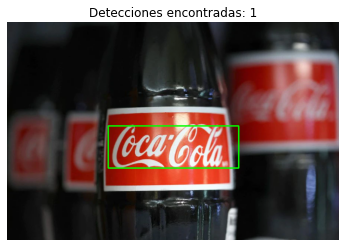

In [17]:
# Logo 1
detecciones_finales, img_con_detecciones = template_matching_multiple(
    LOGO_1, 
    TEMPLATE, 
    min_scale=1.5, 
    max_scale=5, 
    step=0.1, 
    threshold=0.37, 
    use_inverted_template=True,  # Cambia a True si quieres usar el template invertido
    scaling_factor=2
)

plt.imshow(img_con_detecciones)
plt.title(f'Detecciones encontradas: {len(detecciones_finales)}')
plt.axis('off')
plt.savefig('logo_1_multi_temp_match.png', facecolor='white')
plt.show()

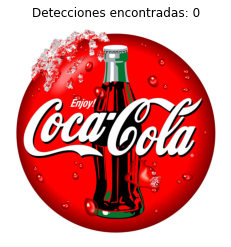

In [18]:
# Logo 2
detecciones_finales, img_con_detecciones = template_matching_multiple(
    LOGO_2, 
    TEMPLATE, 
    min_scale=2, 
    max_scale=10, 
    step=0.5, 
    threshold=0.37, 
    use_inverted_template=True,  # Cambia a True si quieres usar el template invertido
    scaling_factor=2
)

plt.imshow(img_con_detecciones)
plt.title(f'Detecciones encontradas: {len(detecciones_finales)}')
plt.axis('off')
plt.savefig('logo_2_multi_temp_match.png', facecolor='white')
plt.show()

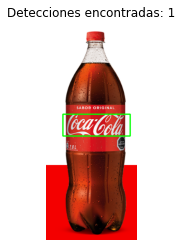

In [19]:
# Logo 3
detecciones_finales, img_con_detecciones = template_matching_multiple(
    LOGO_3, 
    TEMPLATE, 
    min_scale=0.5, 
    max_scale=2, 
    step=0.1, 
    threshold=0.37, 
    use_inverted_template=True,  # Cambia a True si quieres usar el template invertido
    scaling_factor=2
)

plt.imshow(img_con_detecciones)
plt.title(f'Detecciones encontradas: {len(detecciones_finales)}')
plt.axis('off')
plt.savefig('logo_3_multi_temp_match.png', facecolor='white')
plt.show()

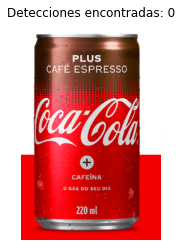

In [20]:
# Logo 4
detecciones_finales, img_con_detecciones = template_matching_multiple(
    LOGO_4, 
    TEMPLATE, 
    min_scale=0.5, 
    max_scale=2, 
    step=0.01, 
    threshold=0.37, 
    use_inverted_template=True,  # Cambia a True si quieres usar el template invertido
    scaling_factor=2
)

plt.imshow(img_con_detecciones)
plt.title(f'Detecciones encontradas: {len(detecciones_finales)}')
plt.axis('off')
plt.savefig('logo_4_multi_temp_match.png', facecolor='white')
plt.show()

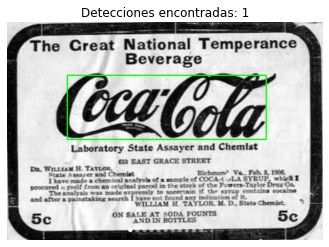

In [21]:
# Logo 5
detecciones_finales, img_con_detecciones = template_matching_multiple(
    LOGO_5, 
    TEMPLATE, 
    min_scale=2, 
    max_scale=5, 
    step=0.1, 
    threshold=0.37, 
    use_inverted_template=False,
    scaling_factor=2
)

plt.imshow(img_con_detecciones)
plt.title(f'Detecciones encontradas: {len(detecciones_finales)}')
plt.axis('off')
plt.savefig('logo_5_multi_temp_match.png', facecolor='white')
plt.show()

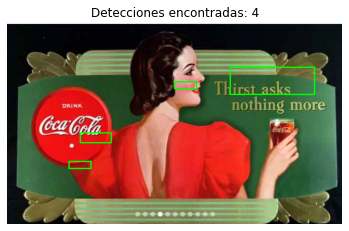

In [32]:
# Logo 6
detecciones_finales, img_con_detecciones = template_matching_multiple(
    LOGO_6, 
    TEMPLATE, 
    min_scale=0.5, 
    max_scale=2, 
    step=0.01, 
    threshold=0.3, 
    use_inverted_template=False,
    scaling_factor=2
)

plt.imshow(img_con_detecciones)
plt.title(f'Detecciones encontradas: {len(detecciones_finales)}')
plt.axis('off')
plt.savefig('logo_6_multi_temp_match.png', facecolor='white')
plt.show()